In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch

sys.path.append(os.path.abspath(".."))

from models.lstm import (create_model, create_sequences, evaluate_model,
                         train_model)
from utils.plotting import plot_train_val, plot_train_val_losses, plot_usage
from utils.preprocess import (add_spotprice, add_time_based_features,
                              add_weather_forecast, interpolate_missing_hours,
                              split_train_val)

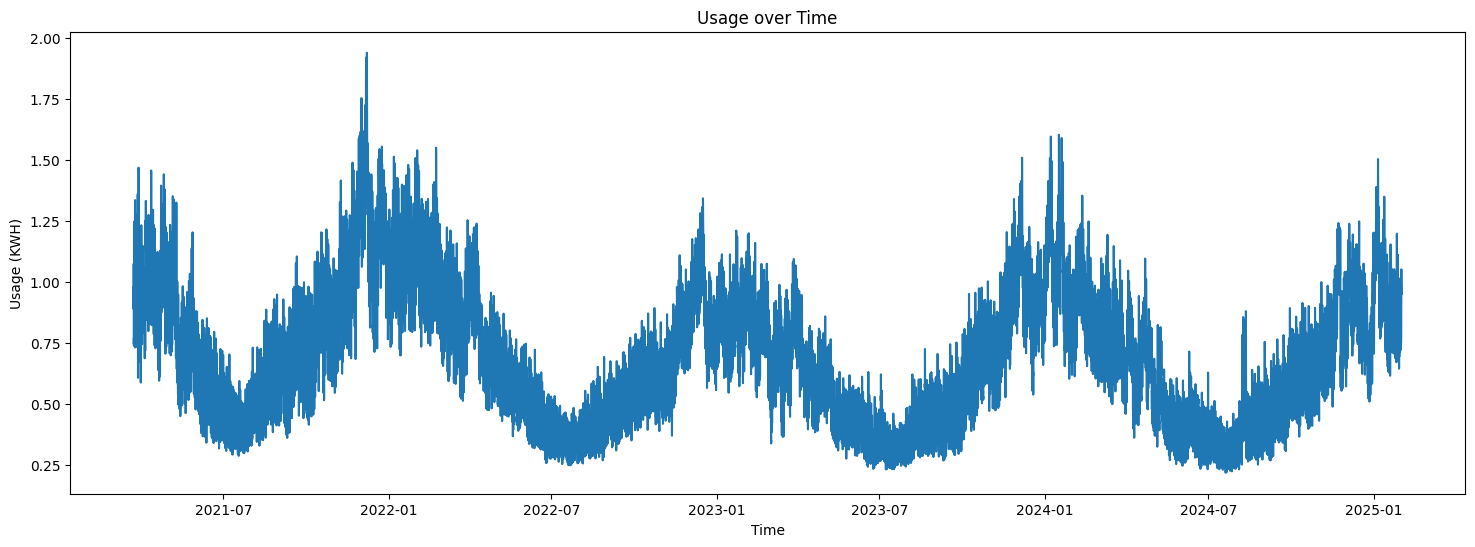

In [2]:
df_raw = pd.read_csv('../data/cons_sthlm_mean_large.csv')
df = interpolate_missing_hours(df_raw)
df = add_time_based_features(df)

spot_price_path = '../data/spotprices.csv'
se_area = 'SE3'
df = add_spotprice(df, spot_price_path, se_area)

weather_path = '../data/open-meteo-stockholm.csv'
#columns_to_add = ['temperature_2m']
columns_to_add = ['temperature_2m', 'precipitation', 'direct_radiation', 'uv_index', 'wind_speed_10m']
df = add_weather_forecast(df, weather_path, columns_to_add)

plot_usage(df)

In [3]:
df

,USAGE_AT,MONTH,DAY_OF_MONTH,WEEKDAY,HOUR,SPOTPRICE_SEK_BY_KWH,temperature_2m,precipitation,direct_radiation,uv_index,wind_speed_10m,USAGE_KWH
0,2021-03-23 00:00:00+00:00,3,23,1,0,0.28302,2.6,0.0,0.0,0.0,7.1,0.976258
1,2021-03-23 01:00:00+00:00,3,23,1,1,0.27808,2.6,0.0,0.0,0.0,7.1,0.964150
2,2021-03-23 02:00:00+00:00,3,23,1,2,0.26894,2.5,0.0,0.0,0.0,7.2,0.953400
3,2021-03-23 03:00:00+00:00,3,23,1,3,0.27642,2.4,0.0,0.0,0.0,7.2,0.889413
4,2021-03-23 04:00:00+00:00,3,23,1,4,0.42936,2.3,0.0,0.0,0.0,7.6,0.908430
...,...,...,...,...,...,...,...,...,...,...,...,...
33860,2025-01-31 20:00:00+00:00,1,31,4,20,0.88248,0.7,0.0,0.0,0.0,13.3,0.985828
33861,2025-01-31 21:00:00+00:00,1,31,4,21,0.86239,0.3,0.0,0.0,0.0,14.4,0.993425
33862,2025-01-31 22:00:00+00:00,1,31,4,22,0.51394,-0.0,0.0,0.0,0.0,14.4,0.987878
33863,2025-01-31 23:00:00+00:00,1,31,4,23,0.37785,-0.2,0.0,0.0,0.0,14.8,0.969646


In [4]:
columns = df.columns.tolist()

columns

['USAGE_AT',
 'MONTH',
 'DAY_OF_MONTH',
 'WEEKDAY',
 'HOUR',
 'SPOTPRICE_SEK_BY_KWH',
 'temperature_2m',
 'precipitation',
 'direct_radiation',
 'uv_index',
 'wind_speed_10m',
 'USAGE_KWH']

In [5]:
# NOTE: Variables for Sequence generation, splitting, and scaling

sequence_length = 24
window = 24

train_split = 0.9
scaler_type = 'minmax'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X, y = create_sequences(df, columns, sequence_length, window)

Using device: cpu


In [6]:
X_train, y_train, X_val, y_val, scaler_x, scaler_y = split_train_val(X, y, train_split, scaler_type, device)

Applying minmax scaling.
X_train shape: torch.Size([30435, 24, 11])
y_train shape: torch.Size([30435, 1])
X_val shape: torch.Size([3382, 24, 11])
y_val shape: torch.Size([3382, 1])


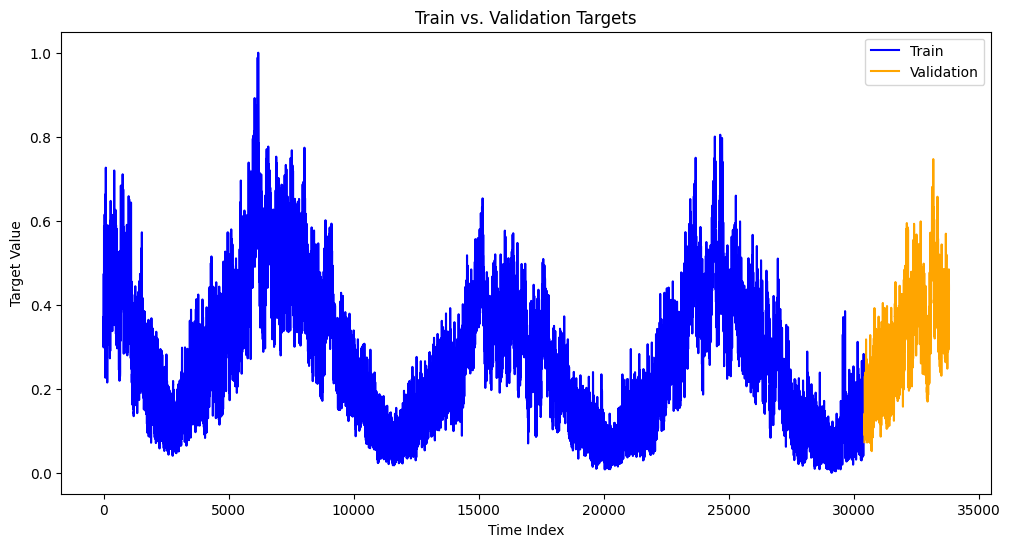

In [7]:
plot_train_val(y_train, y_val)

In [8]:
# NOTE: Model variables
input_dim = X_train.shape[2]
hidden_dim = 50
num_layers = 2
output_dim = 1

model = create_model(input_dim, hidden_dim, num_layers, output_dim, device)

model

LSTMModel(
  (lstm): LSTM(11, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [9]:
lr=0.01
gamma=0.9
noise_std=0.01
num_epochs=300

train_losses, val_losses, model = train_model(
        model, X_train, y_train, X_val, y_val,
        num_epochs, lr, gamma, noise_std
)

Applying Adaptive LR Scheduler: Step Size = 60 epochs, Decay Factor = 0.9
Applying gaussian noise: std = 0.01
Epoch 1/300, Train Loss: 0.0342, Val Loss: 0.0677
Epoch 2/300, Train Loss: 0.1000, Val Loss: 0.0167
Epoch 3/300, Train Loss: 0.0247, Val Loss: 0.0324
Epoch 4/300, Train Loss: 0.0308, Val Loss: 0.0399
Epoch 5/300, Train Loss: 0.0356, Val Loss: 0.0386
Epoch 6/300, Train Loss: 0.0345, Val Loss: 0.0339
Epoch 7/300, Train Loss: 0.0313, Val Loss: 0.0284
Epoch 8/300, Train Loss: 0.0279, Val Loss: 0.0232
Epoch 9/300, Train Loss: 0.0252, Val Loss: 0.0188
Epoch 10/300, Train Loss: 0.0237, Val Loss: 0.0160
Epoch 11/300, Train Loss: 0.0236, Val Loss: 0.0148
Epoch 12/300, Train Loss: 0.0247, Val Loss: 0.0145
Epoch 13/300, Train Loss: 0.0251, Val Loss: 0.0143
Epoch 14/300, Train Loss: 0.0243, Val Loss: 0.0145
Epoch 15/300, Train Loss: 0.0231, Val Loss: 0.0151
Epoch 16/300, Train Loss: 0.0222, Val Loss: 0.0159
Epoch 17/300, Train Loss: 0.0217, Val Loss: 0.0168
Epoch 18/300, Train Loss: 0.0215

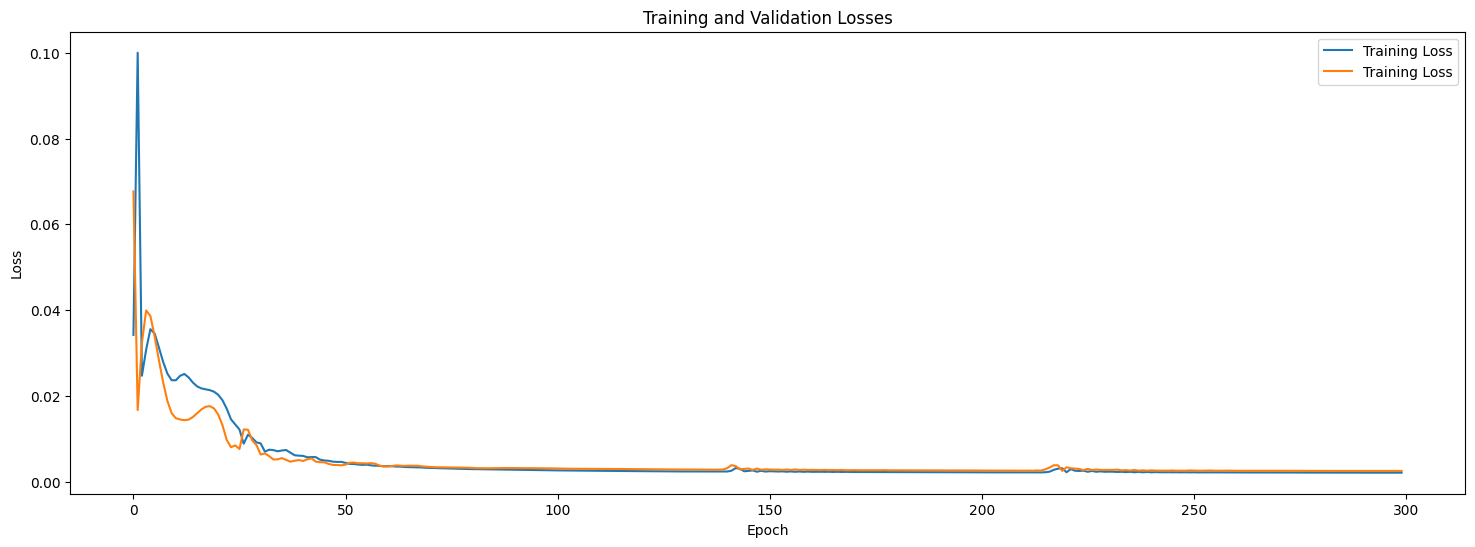

In [10]:
plot_train_val_losses(train_losses, val_losses)

MAE: 0.0652
MAPE: 9.02%
RMSE: 0.0859
kWh actual: 2545.349853515625, kWh pred: 2562.61328125, diff (%): 0.6782339811325073


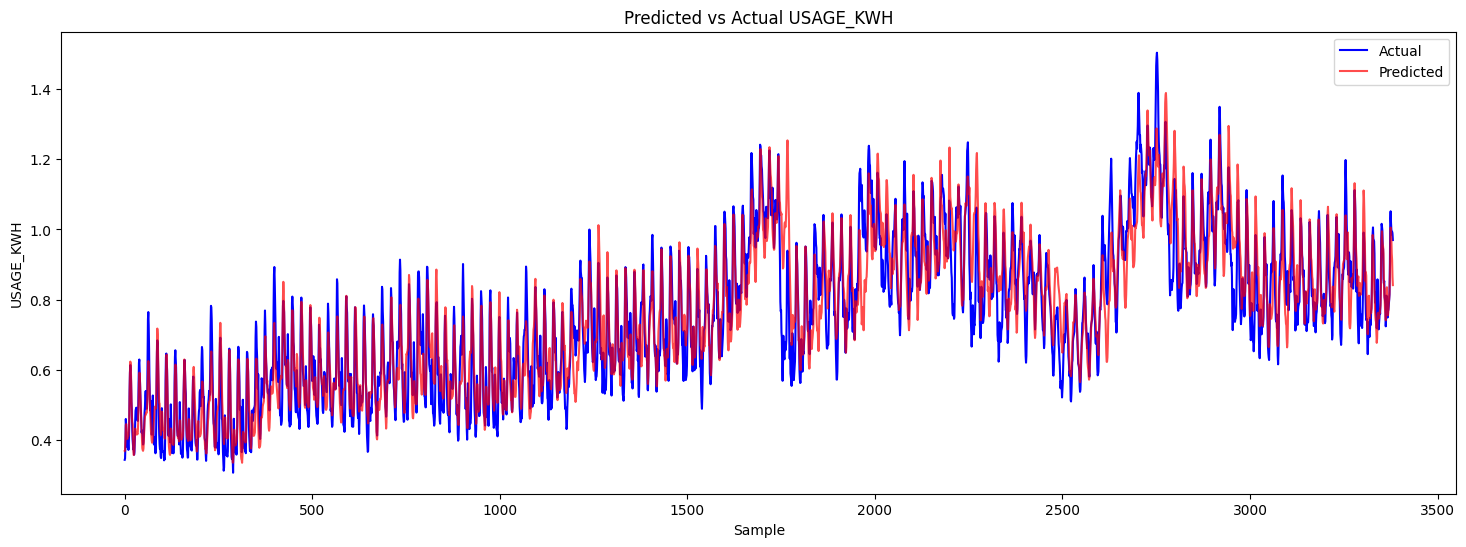

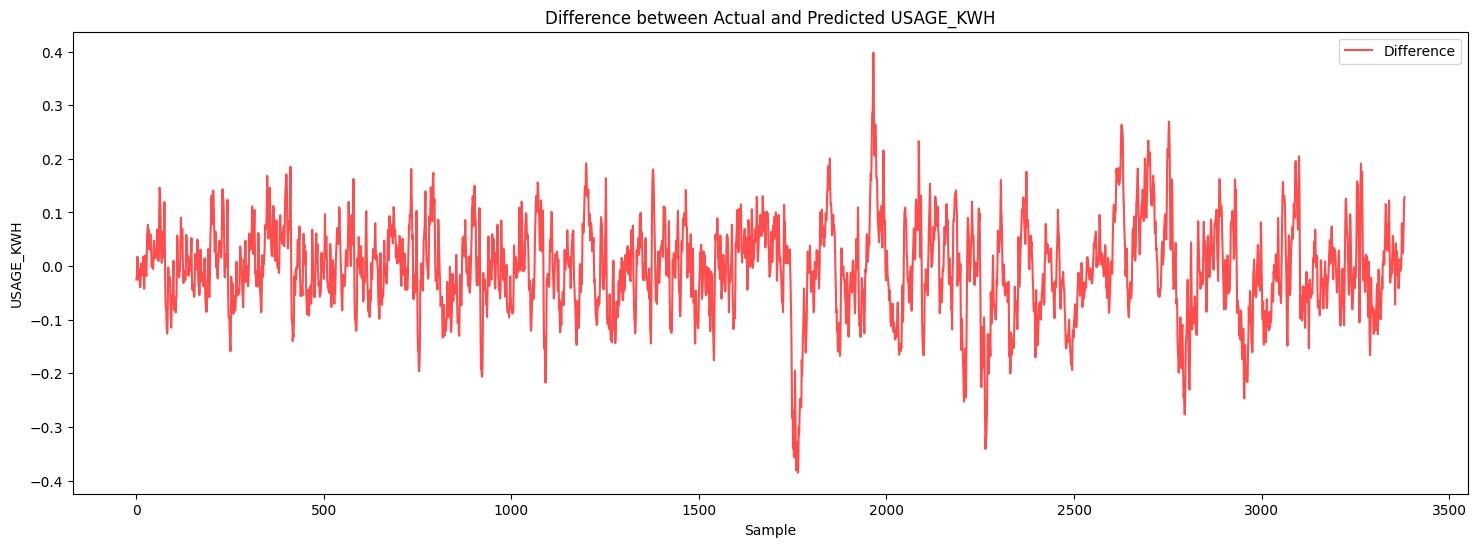

In [12]:
_ = evaluate_model(model, X_val, y_val, scaler_y)